## Predicting failures from age and temperature data

Let's suppose that our hypothesis is that the failure rate is tied to the age of the pipes (as given by the install year) in some way.

We're going to struggle to analyse the full dataset easily so we're going to bin things up a bit to make the datasets smaller. Hopefully there's still an interesting signal!

The first thing we'll do is aggregate suburb names up to postcode level. We'll also use Australia Post postcode data to generate latitudes and longitudes.

Finally we'll join the postcode level age info back onto our failure data to look at whether there's something useful to predict.

### Reading in age data

First we're going to look at the pipe age data from ATCO. This one is much tidier than the faults data.

In [1]:
import pandas as pd
import seaborn
import numpy as np
from os import path

seaborn.set()

# Setting where our data is sitting
data_folder = path.join(
    path.abspath('..'),  # '..' means the directory above this one
    'data')
data_folder

'/Users/jess/Documents/Core - Data Science Workshop/repositories/01-zero-to-data-science/data'

In [2]:
age_file = path.join(data_folder, 'Mains_Age_Profile_Estimation 250516.xlsm')
age_xl = pd.ExcelFile(age_file)
age_xl.sheet_names

['Earliest Mains by Suburbs',
 'ArcFM Data',
 'Filtered Fields',
 'Pivot',
 'Suburb_Age_Length_Material',
 'HP Age Profile',
 'Age Profile Chart',
 'Mean PVC Age Profile']

Next we can parse the data

In [3]:
age_data = age_xl.parse('ArcFM Data')

# rename columns so we aren't yelling all the time
new_names = {
    'INSTALLATI': 'installation',
    'Year': 'year',
    'NOMINALDIA': 'nominal_diameter',
    'ACTUALINTE': 'actual_interior_diameter',
    'MATERIAL': 'material',
    'MEASUREDLE': 'measured_length',
    'MOAP': 'moap',
    'GAS_TYPE': 'gas_type',
    'DIST_LEVEL': 'dist_level',
    'MATERIAL_T': 'material_type',
    'PIPE_NAME': 'pipe_name',
    'SUBURB': 'suburb',
    'POSTCODE': 'postcode',
    'SHAPE_LEN': 'mapped_length'
}
age_data.rename(columns=new_names, inplace=True)

# there are some strange numbers in the age data - we just clip these to 2018
age_data.year = np.clip(age_data.year, age_data.year.min(), 2018)

# Let's see what we've got
age_data.year.describe()

count    559101.000000
mean       1996.216068
std           6.155449
min        1900.000000
25%        1992.000000
50%        1993.000000
75%        1998.000000
max        2018.000000
Name: year, dtype: float64

The next step is to generate quantiles for age for each postcode. We do this by iterating over the records and generating the quantiles row by row (there's probably better ways to do this but we're running towards getting something up at the moment)

In [4]:
features = pd.DataFrame.from_records([
        (postcode, df.year.min(), df.year.quantile(0.25), df.year.median(), 
                    df.year.quantile(0.75), df.year.max())
        for postcode, df in age_data.groupby('postcode')
    ], 
    columns=('postcode', 'q0', 'q25', 'q50', 'q75', 'q100'),
    index='postcode'
)

features.head()

,q0,q25,q50,q75,q100
postcode,,,,,
0,1991.0,1991.0,1993.0,1993.0,2012.0
6000,1991.0,1993.0,1993.0,1994.0,2013.0
6003,1993.0,1993.0,1994.0,1995.0,2011.0
6004,1986.0,1993.0,1993.0,1995.0,2018.0
6005,1993.0,1994.0,1994.0,1998.0,2013.0


Now we can take the postcode data and use this to extract a latitude and longitude for each postcode. We're using an inner join on the postcode indices to only get the values we care about

In [5]:
raw_postcodes = \
    pd.read_csv(path.join(data_folder, 'australian_postcodes.csv')) \
      .dropna(how='any')

# We have to remove duplicate records (there's one for each suburb) so we aggregate them up
postcodes = pd.DataFrame.from_records([
        (postcode, df.long.mean(), df.lat.mean(), ', '.join(df.locality))
        for postcode, df in raw_postcodes.groupby('postcode')
    ],
    columns=('postcode', 'longitude', 'latitude', 'locality'),
    index='postcode'
)
postcodes.head()

,longitude,latitude,locality
postcode,,,
200,149.117136,-35.277272,AUSTRALIAN NATIONAL UNIVERSITY
800,130.955789,-12.801028,DARWIN
801,130.955789,-12.801028,DARWIN
804,130.843310,-12.432181,PARAP
810,130.873472,-12.376967,"ALAWA, BRINKIN, CASUARINA, JINGILI, LEE POINT,..."


Now we can join the two tables together to get one table with all the relevant information

In [6]:
features = features.join(postcodes, how='inner')
features.head()

,q0,q25,q50,q75,q100,longitude,latitude,locality
postcode,,,,,,,,
6000,1991.0,1993.0,1993.0,1994.0,2013.0,115.859912,-31.948762,PERTH
6003,1993.0,1993.0,1994.0,1995.0,2011.0,0.000000,0.000000,"HIGHGATE, NORTHBRIDGE"
6004,1986.0,1993.0,1993.0,1995.0,2018.0,115.874601,-31.956931,EAST PERTH
6005,1993.0,1994.0,1994.0,1998.0,2013.0,115.836896,-31.957070,"KINGS PARK, WEST PERTH"
6006,1993.0,1994.0,1994.0,1996.0,2013.0,115.852913,-31.929340,NORTH PERTH


and now we can see the spread of postcodes around Perth with a quick scatter plot

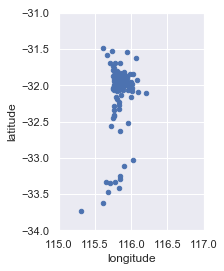

In [7]:
ax = features.plot('longitude', 'latitude', kind='scatter')
ax.set_xlim(115, 117)
ax.set_ylim(-34, -31)
ax.set_aspect(1)

The latitude and longitude columns are really one feature of the data - a geographic point. We should prefer to represent these using a geospatial data type. [geopandas](http://geopandas.org) is an extension to pandas that adds support for geospatial data - you can think of this as giving you an in-memory spatial database (much as pandas gives you an in-memory regular database).

Geopandas also lets you read vector data (e.g. shapefiles) directly which can be really handy when you want to munge spatial and non-spatial data together.

First we transform the dataframe to a geopandas GeoDataFrame

In [8]:
import geopandas as gpd
from shapely.geometry import Point

points = zip(features.longitude, features.latitude)
geometry = [Point(p) for p in points]
crs = {'init': 'epsg:4326'}  # WGS84 coordinate system)

# now we do the conversion
features = gpd.GeoDataFrame(features, crs=crs, geometry=geometry)

Then we can use geoplot to plot our data nicely on the map while visualizing other features

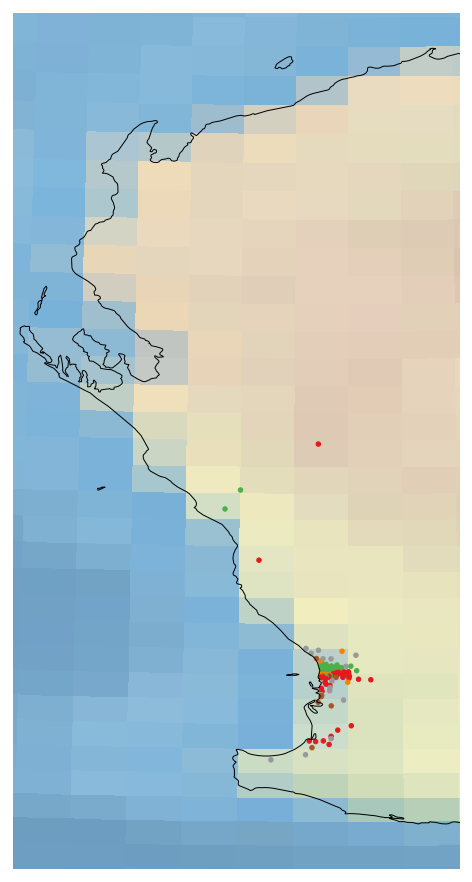

In [20]:
import matplotlib.pyplot as plt
import geoplot as gplt
import geoplot.crs as gcrs

extent = (113, 117, -36, -20)
# extent = (100, 160, -85, 0)
ax = gplt.pointplot(
    features, hue='q50', 
    extent=extent, 
    projection=gcrs.AlbersEqualArea(central_longitude=116, central_latitude=-32.5))
ax.coastlines(resolution='10m')
ax.stock_img()

# Make sure we're plotting equal aspect ratio
aspect = (extent[3] - extent[2]) / (extent[1] - extent[0])
plt.gcf().set_size_inches(8, 8 * aspect)

### Aligning suburb codes from faults data

Next we need to align the shortened suburb names from the faults data with the long versions in our postcode data.

There's quite a few of these so it's worth thinking how to do this programatically.

First we load up our clean data

In [23]:
import feather

feather_file = path.join(data_folder, 'faults_data_2010_2016.feather')
clean = feather.read_dataframe(feather_file)

So lets take a look at what we've got

In [36]:
abbrev_subrubs = clean.suburb.unique()
abbrev_subrubs[:5]

[CAPEL, PNJRR, BSNDN, WNGRA, ALKMS]
Categories (418, object): [CAPEL, PNJRR, BSNDN, WNGRA, ..., PKLDS, FURDALE, RED H, WNGNG]

In [34]:
full_suburbs = age_data.suburb.unique()
full_suburbs[:5]

array(['PALMYRA', 'BICTON', 'KARDINYA', 'EAST FREMANTLE', 'NORTH FREMANTLE'], dtype=object)

Let's write a little function to test whether one string is an abbreviation for the other.

In [39]:
def is_abbrev(abbrev, text):
    """ 
    Check whether abbrev is a valid abbreviation for text
    
    Parameters:
        abbrev - the abbreviated text
        text - the text to match against
    """
    try:
        abbrev=abbrev.lower()
        text=text.lower()
        words=text.split()
    except AttributeError:
        # We don't have text!
        return False
    if not abbrev:
        return True
    if abbrev and not text:
        return False
    if abbrev[0]!=text[0]:
        return False
    else:
        return (is_abbrev(abbrev[1:],' '.join(words[1:])) or
                any(is_abbrev(abbrev[1:],text[i+1:])
                    for i in range(len(words[0]))))

Now we can match one set of suburbs against the other. To speed things up we're going to assume that the abbreviation and suburb start with the same letter

In [46]:
suburb_mapping = {}
for abbrev in abbrev_subrubs:
    # Loop through the list and check whether we have an abbreviation
    possible_matches = [s for s in full_suburbs if is_abbrev(abbrev, s)]
    
    # We're lazy and we'll just take the first match
    if possible_matches:
        suburb_mapping[abbrev] = possible_matches[0]
    else:
        print(f"Couldn't work out {abbrev}")
        suburb_mapping[abbrev] = None

Couldn't work out nan
Couldn't work out WLKWY
Couldn't work out BRD WOOD
Couldn't work out CLIFTON
Couldn't work out LNDSLDE
Couldn't work out VINES
Couldn't work out NOWRGP
Couldn't work out WHITMN
Couldn't work out OCCNR
Couldn't work out BWICK JN
Couldn't work out CRCKD BK
Couldn't work out DPDLE
Couldn't work out FURDALE


and we're done!

In [51]:
list(suburb_mapping.items())[:10]

[('CAPEL', 'CAPEL'),
 ('PNJRR', 'PINJARRA'),
 ('BSNDN', 'BASSENDEAN'),
 ('WNGRA', 'WANGARA'),
 ('ALKMS', 'ALKIMOS'),
 (nan, None),
 ('WLGEE', 'WILLAGEE'),
 ('E FTLE', 'EAST FREMANTLE'),
 ('SPNCR PRK', 'SPENCER PARK'),
 ('MT CLRNC', 'MOUNT CLARENCE')]

In [52]:
clean.head()

,pipe_size,code_group_0,code_group_1,pressure_rating,pipe_material,damage_code,cause_code,object_part_code,location,suburb
0,150.0,MNWORK,MNREQUST,HP,ST,CHCK,CUST,PIPE,BS,CAPEL
1,50.0,MNWORK,MNREQUST,HP,ST,CHCK,AGAS,PIPE,MA,PNJRR
2,80.0,SNSERSTD,NaN,HP,ST,NEW,NaN,PIPE,NM,BSNDN
3,100.0,MNWORK,MNCAUSE,MP,PVC,CHCK,3PTY,PIPE,NM,WNGRA
4,225.0,MNWORK,MNREQUST,HP,PE,CHCK,CUST,PIPE,NM,ALKMS


### Downloading temperature data

We're going to use bomber to do the download

In [10]:
!conda install cartopy geopandas

Solving environment: done

## Package Plan ##

  environment location: /anaconda3/envs/week01

  added / updated specs: 
    - cartopy
    - geopandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pyproj-1.9.5.1             |   py36h508ed2a_3          58 KB  conda-forge
    pyshp-1.2.12               |             py_0          22 KB  conda-forge
    libspatialindex-1.8.5      |       hfc679d8_3         693 KB  conda-forge
    libxslt-1.1.32             |       h88dbc4e_2         528 KB  conda-forge
    requests-2.19.1            |           py36_1          94 KB  conda-forge
    munch-2.3.2                |             py_0           8 KB  conda-forge
    gdal-2.2.4                 |   py36hb00a9d7_1         865 KB  conda-forge
    shapely-1.6.4              |   py36h164cb2d_1         318 KB  conda-forge
    psycopg2-2.7.5             |   py36hdffb7b8_1         286 KB  conda-forge
 

In [1]:
import bomber

bomber.measurements.DATASETS

You need to install p7zip - try with `brew install p7zip`


{'temperature': ['maxave', 'minave'],
 'rainfall': ['totals'],
 'vprp': ['vprp09', 'vprp15'],
 'solar': ['solarave'],
 'ndvi': ['ndviave']}

In [2]:
bomber.__version__

'0.0.5.dev2'

In [3]:
bomber.get_measurements(
    dataset='temperature', 
    variable='maxave',
    year=2010,
    month=1
)

FileNotFoundError: [Errno 2] No such file or directory: '7za': '7za'

In [ ]:
bomber.grid_to_geotiff